In [1]:
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

In [ ]:
#Location & Geometry
lat, lon = 30.59, 114.30 # Wuhan, China
location = pvlib.location.Location(lat, lon, 'Asia/Shanghai', name= 'Wuhan')
surface_tilt = 30
surface_azimuth = 180

In [39]:
weather = pd.read_csv('data/raw/wuhan_tmy.csv', index_col=0, parse_dates=True)

In [ ]:
# Calculate solar zenith and azimuth for every hour of the year
solpos = location.get_solarposition(weather.index)
#Plane of Array (POA)
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    solar_zenith=solpos['apparent_zenith'],
    solar_azimuth=solpos['azimuth'],
    dni=weather['dni'],
    dhi=weather['dhi'],
    ghi=weather['ghi']
)
print(f"Max POA Irradiance: {poa_irradiance['poa_global'].max():.2f} W/m^2")

In [ ]:
# Cell Temp Calculation
parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

cell_temperature = pvlib.temperature.sapm_cell(
    poa_global=poa_irradiance['poa_global'],
    temp_air=weather['temp_air'],
    wind_speed=weather['wind_speed'],
    **parameters # Unpacking coefficients: a, b, deltaT
)

In [44]:
# System Capacity: 10 kW (DC)
# Temperature Coefficient: -0.4%/°C (Standard Poly/Mono-Si)
pdc0 = 10000
gamma_pdc = -0.004
dc_power = pvlib.pvsystem.pvwatts_dc(
    effective_irradiance=poa_irradiance['poa_global'],
    temp_cell=cell_temperature,
    pdc0=pdc0,
    gamma_pdc=gamma_pdc,
    temp_ref=25 # STC Reference Temperature
).fillna(0) # Sanitize NaNs (Nighttime -> 0 W)
print(f"Max DC Power: {dc_power.max():.2f} W")

Max DC Power: 9500.47 W


In [57]:
# Inverter parameters
# Undersized to visualize clipping
pac0 = 6500 # 6.5kW inverter
inverter_efficiency = 0.96 # 96% efficiency

ac_unclipped = pvlib.inverter.pvwatts(
    pdc=dc_power,
    pdc0=pdc0,
    eta_inv_nom=inverter_efficiency
)
# Clipping (Power Limiting)
ac_power = ac_unclipped.fillna(0).clip(lower=0, upper=pac0)
print(f"max AC Power: {ac_power.max():.2f} W")

max AC Power: 6500.00 W


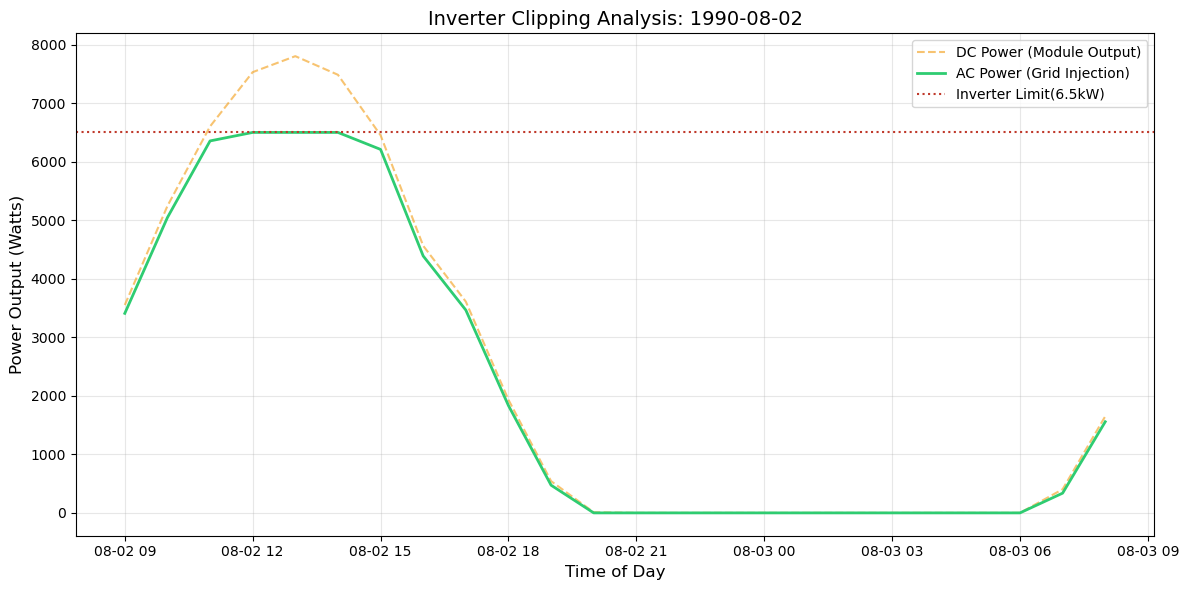

In [ ]:
target_date = '1990-08-02'
# Convert to local time for plotting
dc_plot = dc_power[target_date].tz_convert('Asia/Shanghai')
ac_plot = ac_power[target_date].tz_convert('Asia/Shanghai')
plt.figure(figsize=(12,6), dpi=100)

# DC Power
plt.plot(dc_plot,
         label="DC Power (Module Output)",
         color='organe', alpha=0.6, linestyle='--')

# AC Power
plt.plot(ac_plot,
         label="AC Power (Grid Injection)",
         color='green', linewidth=2)

# Inverter Limit Line
plt.axhline(y=pac0, color='red',linestyle=':', label=f'Inverter Limit({pac0/1000}kW)')
plt.title(f'Inverter Clipping Analysis: {target_date}', fontsize=14)
plt.ylabel('Power Output (Watts)', fontsize=12)
plt.xlabel('Time of Day', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
# Annual Simulation Results
total_ac = ac_power.sum() / 1000  # kWh
total_unclipped = ac_unclipped.sum() / 1000  # kWh

loss = total_unclipped - total_ac
loss_percent = (loss / total_unclipped) * 100

print(f"Annual AC Output: {total_ac:.0f} kWh")
print(f"Estimated Clipping Loss: {loss_percent:.2f} %")

Annual AC Output: 13758 kWh
Estimated Clipping Loss: 4.24 %
